In [1]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-12-14 11:41:01.418350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 11:41:01.552715: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 11:41:02.344551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-14 11:41:02.344636: W te

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
with tf.compat.v1.Session(config=config) as sess:

    # 메모리 40% 할당
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.001
    sess = tf.compat.v1.Session(config=config)

2023-12-14 11:41:03.228149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 11:41:04.029196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-14 11:41:04.046414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Accuracy

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+10)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return 1000 * tf.math.minimum(arg1, arg2)

temp_learning_rate_schedule = CustomSchedule(256,1000000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

2023-12-14 11:41:05.589746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [4]:
import numpy as np
tf.multiply(tf.reduce_sum(tf.one_hot([[1,2]]*100,200),axis=1),[[1,0]*100]*100)

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [5]:
temp_learning_rate_schedule(15)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5000001e-05>

In [43]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        positions = np.array([0]+[0]+[i+2 for i in range(198)])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    
    
    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs,attention_mask=tf.cast(np.array([[1]+[0]+[1]*198] + [[0]+[1]*199] + [[0]*2+[1]*198]*198),bool))
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
    
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(732,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        inputs = tf.reshape(inputs,[-1,200])
        hidden = self.embedding(inputs)
        
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [44]:
from tensorflow.keras import layers
class BERT_all(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,vocab_num=1300):
        super(BERT_all, self).__init__()
        self.transform_block = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,vocab_num,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(1300,activation = 'softmax')
        
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        hidden = self.embedding(inputs)
        for i in range(8):
            hidden = self.transform_block(hidden)
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = tf.keras.layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [45]:

class BERT_norm(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT_norm, self).__init__()
        self.transform_block_trainable = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.transform_block = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.transform_block.trainable = False
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(661,activation = 'softmax')
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        hidden = self.embedding(inputs)

        for i in range(8):
            hidden = self.transform_block(hidden)
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [46]:
from rdkit import Chem
from tqdm import tqdm
def Chem_generator(smiles,tox_info):
    res_list = []
    res_tox_info = []
    for index1,i in tqdm(enumerate(smiles)):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=20 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
        res_tox_info+=[tox_info[index1]]*len(list(set(temp)))
    return res_list,res_tox_info

In [47]:
def Chem_generator_val(smiles):
    res_list = []
    len_list = []
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=20 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
        len_list.append(len(list(set(temp))))
    return res_list,len_list

In [205]:
def predict(model,results,len_list):
    index = 0
    res = model.predict(results,verbose=0)
    result_list = []
    for i in len_list:
        temp = res[index:index+i]
        result_list.append(np.average(temp,axis=0))
        index = index+i
    return np.array(result_list)

In [49]:
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()

model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 bert_4 (BERT)                  (None, 732)          18029742    ['input_10[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
Total params: 18,029,742
Trainable params: 18,029,742
Non-trainable params: 0
_____________

In [50]:
BERT_parameters = model.get_weights()[:130]

In [51]:

auc = AUC(name='auc')
acc = Accuracy(name = 'acc')
inputs = Input(shape = (200,),dtype=tf.int32)
bert_layer = BERT(256,6,1024)

hidden = bert_layer(inputs,None)

hidden1 = hidden[:,:,0]
output = tf.keras.layers.Dense(256,activation = 'gelu')(hidden1)
output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)
output = tf.reduce_mean(output,axis=1)

BERT_Classifier = Model(inputs = [inputs], outputs=[output])


BERT_Classifier.layers[1].set_weights(BERT_parameters)
BERT_Classifier.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics=['acc',auc])
BERT_Classifier.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200)]             0         
                                                                 
 bert_5 (BERT)               (None, 200, 256)          17781760  
                                                                 
 tf.__operators__.getitem_7   (None, 200)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_122 (Dense)           (None, 256)               51456     
                                                                 
 dense_123 (Dense)           (None, 1)                 257       
                                                                 
 tf.math.reduce_mean_5 (TFOp  (None,)                  0         
 Lambda)                                                  

In [70]:
auc = AUC(name='auc')
acc = Accuracy(name = 'acc')
inputs = Input(shape = (200,),dtype=tf.int32)

hidden = bert_layer(inputs,None)

hidden1 = hidden[:,1]
output = tf.keras.layers.Dense(256,activation = 'gelu')(hidden1)
output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)


BERT_Classifier1 = Model(inputs = [inputs], outputs=[output])


BERT_Classifier1.layers[1].set_weights(BERT_parameters)
BERT_Classifier1.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics=['acc',auc])
BERT_Classifier1.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 200)]             0         
                                                                 
 bert_5 (BERT)               (None, 200, 256)          17781760  
                                                                 
 tf.__operators__.getitem_13  (None, 256)              0         
  (SlicingOpLambda)                                              
                                                                 
 dense_170 (Dense)           (None, 256)               65792     
                                                                 
 dense_171 (Dense)           (None, 1)                 257       
                                                                 
Total params: 17,847,809
Trainable params: 17,847,809
Non-trainable params: 0
______________________________________________

In [71]:
inputs = Input(shape = (200,),dtype=tf.int32)
hidden = bert_layer(inputs,None)
hidden1 = hidden[:,:,1]
output = tf.keras.layers.Dense(256,activation = 'gelu')(hidden1)
output = tf.keras.layers.Dense(1)(output)
BERT_Regression = Model(inputs = [inputs], outputs=[output])
BERT_Regression.compile(optimizer='Adam',loss = 'mse',metrics=['r2_score'])
BERT_Regression.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 200)]             0         
                                                                 
 bert_5 (BERT)               (None, 200, 256)          17781760  
                                                                 
 tf.__operators__.getitem_14  (None, 200)              0         
  (SlicingOpLambda)                                              
                                                                 
 dense_172 (Dense)           (None, 256)               51456     
                                                                 
 dense_173 (Dense)           (None, 1)                 257       
                                                                 
Total params: 17,833,473
Trainable params: 17,833,473
Non-trainable params: 0
______________________________________________

In [265]:

auc = AUC(name='auc')
acc = Accuracy(name = 'acc')
inputs = Input(shape = (200,),dtype=tf.int32)
hidden = BERT(256,6,1024)(inputs,None)

BERT_model = Model(inputs = [inputs],outputs = [hidden])

hidden1 = hidden[:,:,0]
output = tf.keras.layers.Dense(256,activation = 'gelu')(hidden1)
output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)

BERT_Classifier = Model(inputs = [inputs], outputs=[output])


BERT_Classifier.layers[1].set_weights(BERT_parameters)
BERT_Classifier.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 200)]             0         
                                                                 
 bert_10 (BERT)              (None, 200, 256)          17781760  
                                                                 
 tf.__operators__.getitem_17  (None, 200)              0         
  (SlicingOpLambda)                                              
                                                                 
 dense_232 (Dense)           (None, 256)               51456     
                                                                 
 dense_233 (Dense)           (None, 1)                 257       
                                                                 
Total params: 17,833,473
Trainable params: 17,833,473
Non-trainable params: 0
______________________________________________

In [305]:
from sklearn.model_selection import train_test_split


tox_name = 'hERG_Karim'

with open('./AIS_Tox_data/'+tox_name,'rb') as file:
    train,label,len_20 = pickle.load(file)[0] 
         



<BarContainer object of 95 artists>

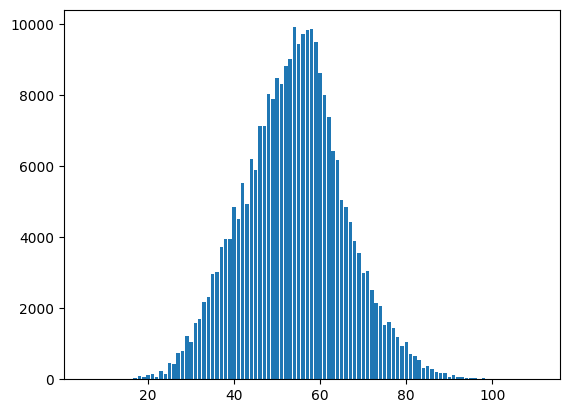

In [306]:
temp_dict = {}

for i in train:
    try:
        temp_dict[len(i)] = temp_dict[len(i)] + 1
    except:
        temp_dict[len(i)] = 1
        
plt.bar(temp_dict.keys(),temp_dict.values())

In [307]:
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)

In [308]:
len(word2idx)

732

In [309]:
except_dict = {}

for i in train:
    for j in i:
        try:
            word2idx[j]
        except:
            try:
                except_dict[j]
            except:
                except_dict[j] = len(except_dict) + 1
                


In [310]:
len(train)

268795

In [311]:
print(word2idx)

{'<start>': 1, '<end>': 2, '<unknown1>': 3, '<unknown2>': 4, '<unknown3>': 5, '<unknow4>': 6, '<unknown5>': 7, '[S;!R;CCOO]': 8, '(': 9, '[c;R;CCS]': 10, '1': 11, '[c;R;CCN]': 12, '[CH;R;CCN]': 13, '2': 14, '[N;R;CCC]': 15, '[C;!R;CNO]': 16, '=': 17, '[O;!R;C]': 18, ')': 19, '[c;R;CCC]': 20, '3': 21, '[cH;R;CN]': 22, '[n;R;CN]': 23, '[n;R;CCN]': 24, '[CH3;!R;N]': 25, '[CH2;R;CN]': 26, '[CH2;R;CC]': 27, '[nH;R;CN]': 28, '[O;!R;S]': 29, '[CH3;!R;S]': 30, '[NH;!R;CC]': 31, '[C;!R;NOO]': 32, '[O;!R;CC]': 33, '[CH;R;CCO]': 34, '[CH2;R;CS]': 35, '[S;R;CCOO]': 36, '[cH;R;CC]': 37, '[c;R;CCF]': 38, '[F;!R;C]': 39, '[C;!R;COO]': 40, '[[O-];!R;C]': 41, '[c;R;CCO]': 42, '[OH;!R;C]': 43, '[[NH+];R;CCC]': 44, '[CH2;!R;CN]': 45, '[c;R;CNN]': 46, '[n;R;CCC]': 47, '[n;R;CC]': 48, '[CH;R;CCC]': 49, '[CH3;!R;C]': 50, '[c;R;CNO]': 51, '[nH;R;CC]': 52, '[n;R;CO]': 53, '[o;R;NN]': 54, '[S;!R;CNOO]': 55, '[NH;!R;CS]': 56, '[c;R;NOO]': 57, '[o;R;CC]': 58, '[C;R;CNO]': 59, '[CH;R;CC]': 60, '4': 61, '[NH;R;CC]

In [312]:
Full_dict = {}
for i in train:
    for j in i:
        try:
            except_dict[j]
            Full_dict[j] = Full_dict[j]+1
        except:
            Full_dict[j] = 1
        

In [313]:
for i in except_dict.keys():
    if Full_dict[i]>5:
        print(i,Full_dict[i])

. 7320
[[Br-];!R;] 20
[ClH;!R;] 4880
[[N+];!R;C] 80
[[S+];!R;CCO] 700
[[I-];!R;] 100
[[N+];R;CC] 520
/[H] 560
[[S+];R;CCO] 220
[O;R;CO] 360
[CH2;!R;FO] 20
[[NH+];!R;CS] 20
[O;!R;CO] 20
[OH;!R;O] 20
[C;R;CFN] 80
[[Na+];!R;] 40
[c;R;CSSe] 40
[cH;R;CSe] 40
[se;R;CC] 40
[IH;!R;] 20
[NH3;!R;] 20
[C;!R;CFN] 20
[[o+];R;NN] 20
[S;!R;CP] 80
[P;!R;OOSS] 20
[SH;R;CC] 20
[SH;!R;COO] 20
[[P+];!R;OOSS] 20
[[Cl-];!R;] 20
[[S+];!R;CCNO] 60
[OH2;!R;] 20
[CH;!R;BCN] 60
[B;!R;COO] 40
[OH;!R;B] 80
[B;R;COO] 20
[O;R;BC] 40
[SH;!R;OOO] 40
[S;!R;CFOO] 20
[F;!R;S] 20
[S;!R;AuC] 20
[Au;!R;PS] 20
[P;!R;AuCCC] 20


In [314]:
from difflib import SequenceMatcher
def similar(a, b):    return SequenceMatcher(None, a, b).ratio()

In [315]:
def most_similar(query):

    max = 0
    tokken = ''
    query = query.split(';')
    for i in word2idx.keys():
        key = i.split(';')
        temp2 = 0
        temp3 = 0
        temp1 = similar(query[0],key[0])*10
        try:
            temp2 = similar(query[1],key[1])*2
            temp3 = similar(query[2],key[2])*1
        except:
            pass
        temp = temp1+temp2+temp3
        if temp>max:
            max = temp
            tokken = i
    return tokken

In [316]:
similar_dict = {}

for i in except_dict.keys():
    similar_dict[i] = most_similar(i)

In [317]:
### Data processing
AIS_train = []
for index,i in enumerate(train):
    temp = []
    temp.append(3)
    temp.append(1)
    for j in i:
        try:
            temp.append(word2idx[j])
        except:
            if j != '/[H]':
                word_sim = similar_dict[j]
                if word_sim != '':
                    temp.append(word2idx[word_sim])
            else:
                pass
    if len(temp)>1:
        AIS_train.append(temp)

AIS_train = tf.keras.preprocessing.sequence.pad_sequences(AIS_train, padding='post', maxlen=200)

In [318]:
temp_x = []
temp_y = []
index = 0
for i in len_20:
    temp_x.append(AIS_train[index:index+i])
    temp_y.append(label[index:index+i])
    index = index+i



x_train, x_val, y_train, y_val,_,len_20 = train_test_split(temp_x,temp_y,len_20, test_size=0.1, random_state=42)

temp = []
for i in x_train:
    temp+=list(i)
x_train = np.array(temp)

temp = []
for i in x_val:
    temp+=list(i)
x_val = np.array(temp)

temp = []
for i in y_train:
    temp+=list(i)
y_train = np.array(temp)

temp = []
for i in y_val:
    temp+=list(i)
y_val = np.array(temp)


In [319]:

def R2(y,y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y,y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y,tf.reduce_mean(y))))
    r2 = tf.subtract(1.0,tf.div(residual,total))
    return r2



In [320]:
from tensorflow.keras.optimizers import Adam
BERT_Classifier.compile(loss = 'binary_crossentropy',optimizer=Adam(learning_rate=1e-5),metrics=['acc',AUC(name='auc')])
BERT_Regression.compile(loss = 'mean_squared_error',optimizer=Adam(learning_rate=1e-5),metrics=[R2])

In [321]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
auc = AUC()
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, result_list,y_true,len_20):
        super().__init__()
        self.result_list = result_list
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_true[index:index+i]))
            index = index+i
        
        
        self.y_true = np.array(res)
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        # 에포크가 끝날 때마다 validation 데이터로 모델 평가
        result = predict(self.model,self.result_list,len_20)
        acc = tf.keras.metrics.Accuracy()(self.y_true,np.round(result))
        auc_res = AUC()(self.y_true,result)
        loss = tf.keras.metrics.BinaryCrossentropy()(self.y_true,result)
        auc_res = auc_res.numpy()
        print(f"     val_acc : {acc},    val_auc : {auc_res} val_loss : {loss}")
        if 'val_acc' not in self.history:
            self.history['val_acc'] = [acc]
        else:
            self.history['val_acc'] += [acc]
        if 'val_auc' not in self.history:
            self.history['val_auc'] = [auc_res]
        else:
            self.history['val_auc'] += [auc_res]
        
        if 'val_loss' not in self.history:
            self.history['val_loss'] = [loss]
        else:
            self.history['val_loss'] += [loss]


In [323]:
val_call = CustomCallback(x_val,y_val,len_20)

In [324]:
from tensorflow.keras.optimizers import Adam
BERT_Classifier.compile(loss = 'binary_crossentropy',optimizer=Adam(learning_rate=1e-5),metrics=['acc',AUC(name='auc')])

with tf.device('/device:GPU:0'):
    temp_history = BERT_Classifier.fit(x_train,np.array(y_train),epochs=20,batch_size=32,callbacks=[val_call])

Epoch 1/20
7560/7560 [==============================] - 591s 76ms/step - loss: 0.5946 - acc: 0.7450 - auc: 0.8239
Epoch 2/20
7560/7560 [==============================] - 568s 75ms/step - loss: 0.5512 - acc: 0.7688 - auc: 0.8506
Epoch 3/20
7560/7560 [==============================] - 568s 75ms/step - loss: 0.5201 - acc: 0.7850 - auc: 0.8678
Epoch 4/20
7560/7560 [==============================] - 568s 75ms/step - loss: 0.4963 - acc: 0.7972 - auc: 0.8802
Epoch 5/20
7560/7560 [==============================] - 560s 74ms/step - loss: 0.4771 - acc: 0.8060 - auc: 0.8899
Epoch 6/20
1265/7560 [====>.........................] - ETA: 7:22 - loss: 0.4629 - acc: 0.8135 - auc: 0.8972

In [ ]:
len_20_herg_karim = []
x_val_herg = []
y_val_herg = []
 
number = 0
for index,i in enumerate(len_20):
    if y_val[index][2] == 1 or y_val[index][3] == 1:
        y_val_herg.append(y_val[index])
        len_20_herg_karim.append(i)
        x_val_herg.append(x_val[number:number+i])
    number += i

np.array(len_20_herg_karim) 
np.array(x_val_herg)
np.array(y_val_herg)
    

In [ ]:
evaluate = predict(BERT_Classifier,x_val_herg,len_20_herg)
herg_karim_val_acc = Accuracy()(y_val_herg,evaluate)

In [131]:
#with tf.device('/device:GPU:0'):
    #temp_history = BERT_Classifier.fit(x_train1,y_train1,epochs=50,validation_data=(x_val1,y_val1),batch_size=32,callbacks=[callback])

In [293]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
inputs = Input(shape=(2048,),name='input')
outputs = Dense(250,activation = 'relu')(inputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(40,activation = 'relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(10,activation = 'relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(1,activation = 'sigmoid')(outputs)

model_NN = Model(inputs= [inputs], outputs=[outputs])
model_NN.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_245 (Dense)           (None, 250)               512250    
                                                                 
 dropout_184 (Dropout)       (None, 250)               0         
                                                                 
 dense_246 (Dense)           (None, 40)                10040     
                                                                 
 dropout_185 (Dropout)       (None, 40)                0         
                                                                 
 dense_247 (Dense)           (None, 10)                410       
                                                                 
 dropout_186 (Dropout)       (None, 10)                0  

In [300]:
from tdc.single_pred import Tox
from Module import RDK
train,tox_info = Tox(name=tox_name).get_data(format='DeepPurpose')
bit_string = RDK.smile_to_RDkit(train,2048)
x_train_NN,x_val_NN,y_train_NN,y_val_NN = train_test_split(np.array(bit_string)/1.,np.array(tox_info)/1.,test_size=0.2,random_state=1300)

NameError: name 'tox_name' is not defined

In [295]:
model_NN.compile(loss = 'binary_crossentropy',optimizer='Adam',metrics=['acc',AUC(name = 'auc')])

In [296]:
model_NN.fit(x_train_NN,y_train_NN,epochs=20,validation_data=(x_val_NN,y_val_NN),batch_size=20)

Epoch 1/20
19/19 [==============================] - 2s 25ms/step - loss: 0.6776 - acc: 0.5500 - auc: 0.5922 - val_loss: 0.6358 - val_acc: 0.7895 - val_auc: 0.8232
Epoch 2/20
19/19 [==============================] - 0s 12ms/step - loss: 0.5604 - acc: 0.7579 - auc: 0.8462 - val_loss: 0.5507 - val_acc: 0.7684 - val_auc: 0.8523
Epoch 3/20
19/19 [==============================] - 0s 12ms/step - loss: 0.4158 - acc: 0.8474 - auc: 0.9161 - val_loss: 0.4937 - val_acc: 0.7579 - val_auc: 0.8613
Epoch 4/20
19/19 [==============================] - 0s 12ms/step - loss: 0.2420 - acc: 0.9158 - auc: 0.9772 - val_loss: 0.4565 - val_acc: 0.8105 - val_auc: 0.8776
Epoch 5/20
19/19 [==============================] - 0s 12ms/step - loss: 0.1875 - acc: 0.9395 - auc: 0.9833 - val_loss: 0.5370 - val_acc: 0.8000 - val_auc: 0.8832
Epoch 6/20
19/19 [==============================] - 0s 12ms/step - loss: 0.0949 - acc: 0.9737 - auc: 0.9989 - val_loss: 0.5887 - val_acc: 0.8000 - val_auc: 0.8805
Epoch 7/20
19/19 [====

NameError: name 'Tox_name' is not defined

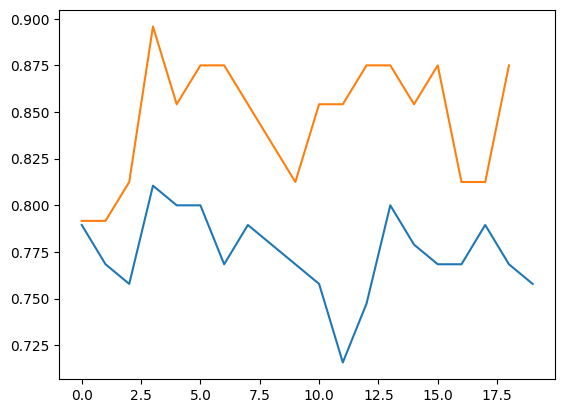

In [298]:
plt.plot([i for i in range(len(model_NN.history.history['val_acc']))],model_NN.history.history['val_acc'],label='bit_Val_ACC data')
plt.plot([i for i in range(len(val_call.history['val_acc']))],val_call.history['val_acc'],label = 'BERT_Val_ACC data')
#plt.plot([i for i in range(len(val_call2.history['val_acc']))],val_call2.history['val_acc'],label = 'BERT_Norm acc data')
plt.title(Tox_name + ' ACC')
plt.xlabel('epoch')
plt.ylabel('score')

plt.legend()

NameError: name 'Tox_name' is not defined

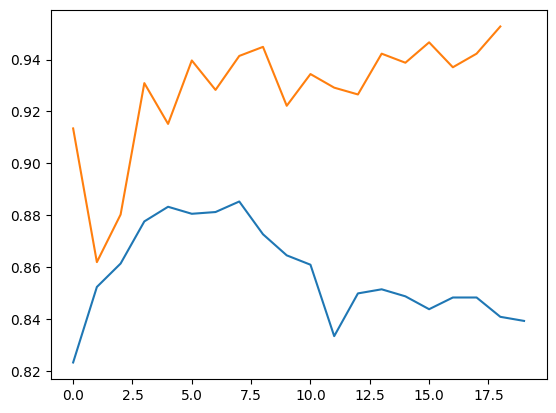

In [299]:
plt.plot([i for i in range(len(model_NN.history.history['val_auc']))],model_NN.history.history['val_auc'],label='bit_Val_AUC data')
plt.plot([i for i in range(len(val_call.history['val_acc']))],val_call.history['val_auc'],label = 'BERT_Val_AUC data')
#plt.plot([i for i in range(len(val_call2.history['val_acc']))],val_call2.history['val_auc'],label = 'BERT_Norm data')
plt.title(Tox_name + ' AUC')
plt.xlabel('epoch')
plt.ylabel('score')

plt.legend()

In [ ]:
model_NN.evaluate(x_test_NN,y_test_NN)

46/46 [==============================] - 0s 10ms/step - loss: 3.4944 - acc: 0.5962 - auc: 0.6115


[3.4943673610687256, 0.5961538553237915, 0.6114746928215027]

In [ ]:
def plot_model_acc(history,model_name=''):
    ## Accuracy plot
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model_name+'Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_model_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
   

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = BERT_model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

2/2 [==============================] - 1s 32ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

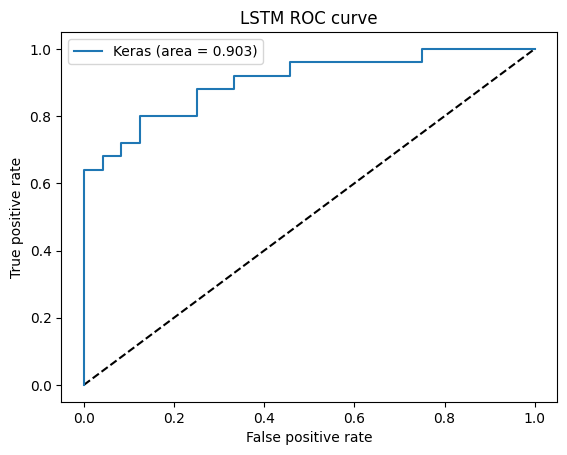

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LSTM ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model_NN.predict(x_val_NN).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_NN, y_pred_keras)

3/3 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

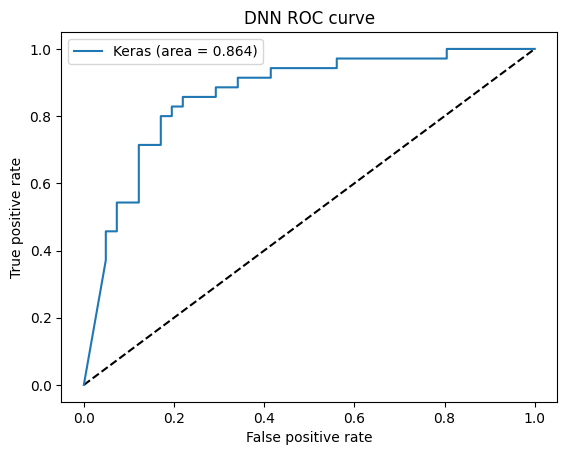

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DNN ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(np.array(temp_image),np.array(temp_tox_image)/1.,test_size=0.2,random_state=125)